In [293]:
import scipy.io

import time
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [294]:
mat = scipy.io.loadmat('Oxford_Battery_Degradation_Dataset_1.mat')

In [295]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

In [296]:
input_data = [
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []]
]

CELL_SIZE = [83, 78, 82, 52, 51, 51, 82, 82]

In [297]:
for i in range(0, 8):
    cell_num = "Cell{}".format(i + 1)
    for j in range(0, CELL_SIZE[i]):
        cyc_num = "cyc{:04d}".format(j * 100)
        try:
            curr = mat[cell_num][0][cyc_num][0][0]["C1ch"][0][0]['q'][0][-1][0]
        except ValueError:
            curr = float("NaN")
        input_data[i][0].append(j)
        input_data[i][1].append(curr)

In [298]:
train_x = []
train_y = []
test_x = [
    [],
    [],
    [],
    []
]
test_y = [
    [],
    [],
    [],
    []
]

In [299]:
for i in range(0, 8):
    df_input = pd.DataFrame(input_data[i]).transpose()
    df_input = df_input.rename(columns={0: "cycle", 1: "q_value"})
    df_input['interpolate_spline'] = df_input['q_value'].interpolate(option='spline')
    df_input['soh'] = df_input['interpolate_spline'] / 740

    df_input = df_input.drop("cycle", axis=1)
    df_input = df_input.drop("q_value", axis=1)
    df_input = df_input.drop("interpolate_spline", axis=1)

    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df_input.values)
    label_sc.fit(df_input.iloc[:, 0].values.reshape(-1, 1))

    lookback = 10
    inputs = np.zeros((len(data) - lookback, lookback, df_input.shape[1]))
    labels = np.zeros(len(data) - lookback)

    for j in range(lookback, len(data)):
        inputs[j - lookback] = data[j - lookback:j]
        labels[j - lookback] = data[j, 0]
    inputs = inputs.reshape(-1, lookback, df_input.shape[1])
    labels = labels.reshape(-1, 1)

    if (i < 4):
        if len(train_x) == 0:
            train_x = inputs[:]
            train_y = labels[:]
        else:
            train_x = np.concatenate((train_x, inputs[:]))
            train_y = np.concatenate((train_y, labels[:]))
    else:
        test_x[i - 4] = inputs
        test_y[i - 4] = labels

In [300]:
np.array(train_x).shape

(255, 10, 1)

In [301]:
np.array(train_y).shape

(255, 1)

In [302]:
np.array(test_x[0]).shape

(41, 10, 1)

In [303]:
np.array(test_y[0]).shape

(41, 1)

In [304]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [305]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [306]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [307]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [308]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=10, model_type="GRU"):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1, EPOCHS + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter,
                                                                                       len(train_loader),
                                                                                       avg_loss / counter))

        current_time = time.process_time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss / len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time - start_time)))
        epoch_times.append(current_time - start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [309]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()

    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))

    print("Evaluation Time: {}".format(str(time.process_time() - start_time)))
    MAE = 0
    RMSE = 0
    for i in range(len(outputs)):
        MAE += np.mean(abs(outputs[i] - targets[i])) / len(outputs)
        RMSE += np.mean((outputs[i] - targets[i]) ** 2) / len(outputs)
    RMSE = math.sqrt(RMSE)
    print("MAE: {}".format(MAE))
    print("RMSE: {}".format(RMSE))
    return outputs, targets, MAE, RMSE

In [310]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")
lstm_model = train(train_loader, lr, model_type="LSTM")

Starting Training of GRU model
Epoch 1......Step: 1/7....... Average Loss for Epoch: 0.2183217704296112
Epoch 1......Step: 2/7....... Average Loss for Epoch: 0.1705252043902874
Epoch 1......Step: 3/7....... Average Loss for Epoch: 0.13943439970413843
Epoch 1......Step: 4/7....... Average Loss for Epoch: 0.11745635978877544
Epoch 1......Step: 5/7....... Average Loss for Epoch: 0.1020483247935772
Epoch 1......Step: 6/7....... Average Loss for Epoch: 0.09568836850424607
Epoch 1......Step: 7/7....... Average Loss for Epoch: 0.09141721416796957
Epoch 1/10 Done, Total Loss: 0.09141721416796957
Total Time Elapsed: 0.890625 seconds
Epoch 2......Step: 1/7....... Average Loss for Epoch: 0.039674561470746994
Epoch 2......Step: 2/7....... Average Loss for Epoch: 0.034835899248719215
Epoch 2......Step: 3/7....... Average Loss for Epoch: 0.0423246460656325
Epoch 2......Step: 4/7....... Average Loss for Epoch: 0.03948215814307332
Epoch 2......Step: 5/7....... Average Loss for Epoch: 0.039194454625248

GRU Evaluation for Cell 5
Evaluation Time: 0.09375
MAE: 0.0063513789084610256
RMSE: 0.020714039037890136


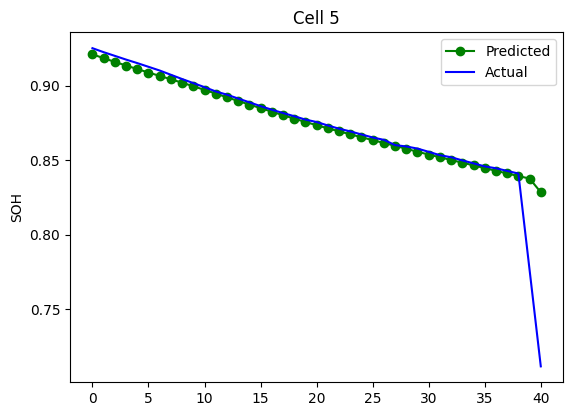

GRU Evaluation for Cell 6
Evaluation Time: 0.03125
MAE: 0.010253328648418271
RMSE: 0.011139028493821554


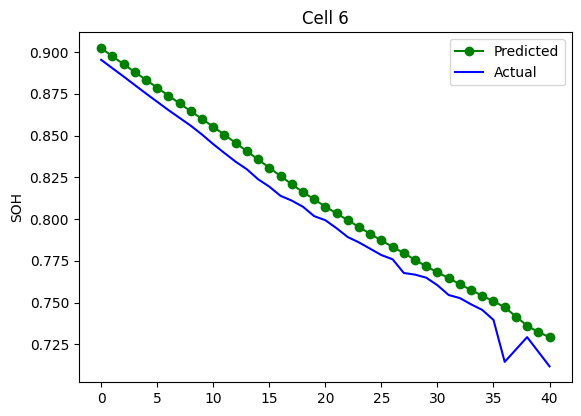

GRU Evaluation for Cell 7
Evaluation Time: 0.234375
MAE: 0.004128169689181102
RMSE: 0.004778078489189247


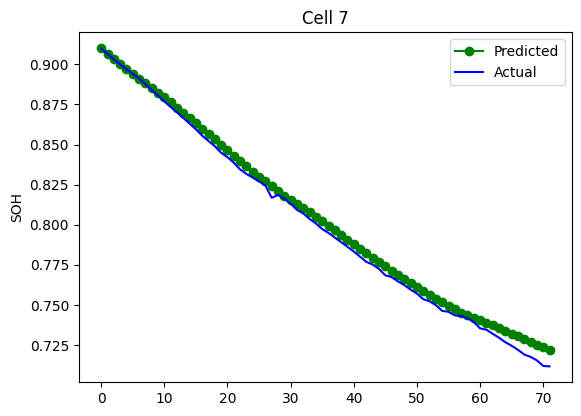

GRU Evaluation for Cell 8
Evaluation Time: 0.125
MAE: 0.0044162900826351876
RMSE: 0.005030339325238253


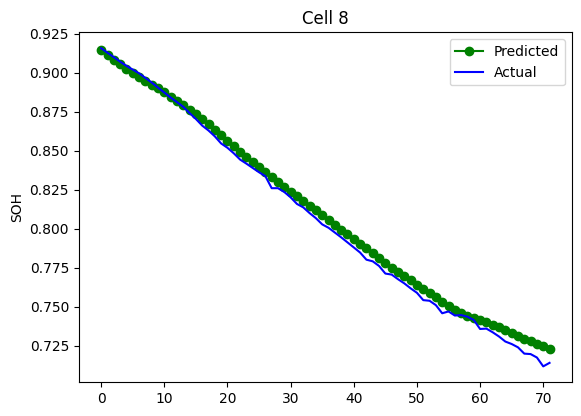

In [311]:
for i in range(0, 4):
    print("GRU Evaluation for Cell {}".format(i + 5))
    gru_outputs, targets, gru_MAE, gru_RMSE = evaluate(gru_model, test_x[i], test_y[i], label_sc)
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
    plt.plot(targets[0][-100:], color="b", label="Actual")
    plt.ylabel('SOH')
    plt.title("Cell {}".format(i + 5))
    plt.legend()
    plt.show()

# MAE and RMSE
# predicted curve
# performance, numerical results

LSTM Evaluation for Cell 5
Evaluation Time: 0.109375
MAE: 0.01319545753067425
RMSE: 0.021275134175864425


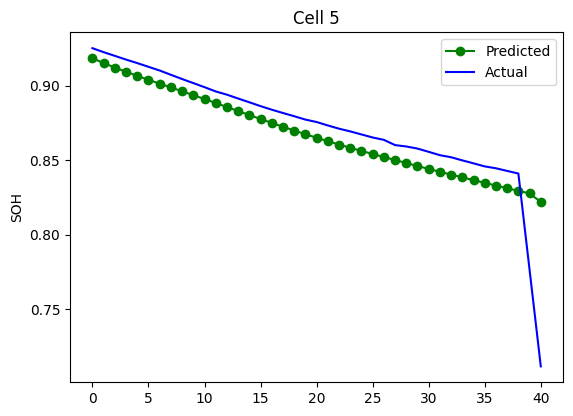

LSTM Evaluation for Cell 6
Evaluation Time: 0.078125
MAE: 0.006101606368427679
RMSE: 0.008362908968819001


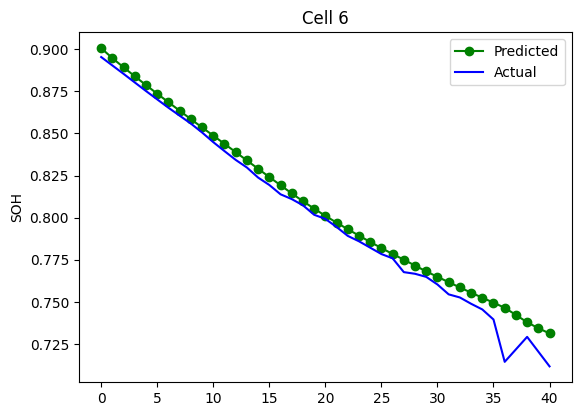

LSTM Evaluation for Cell 7
Evaluation Time: 0.203125
MAE: 0.00399053947946459
RMSE: 0.004854664615269111


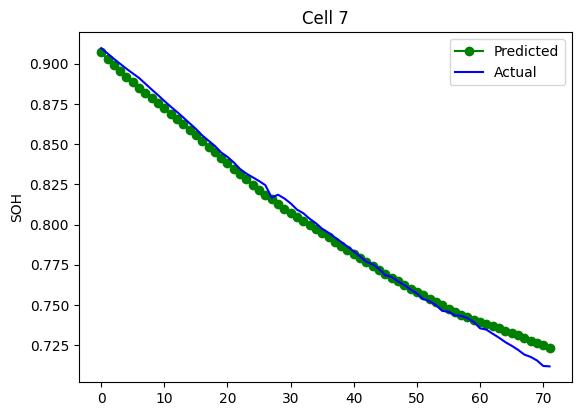

LSTM Evaluation for Cell 8
Evaluation Time: 0.140625
MAE: 0.0042245203121044905
RMSE: 0.005105434276609451


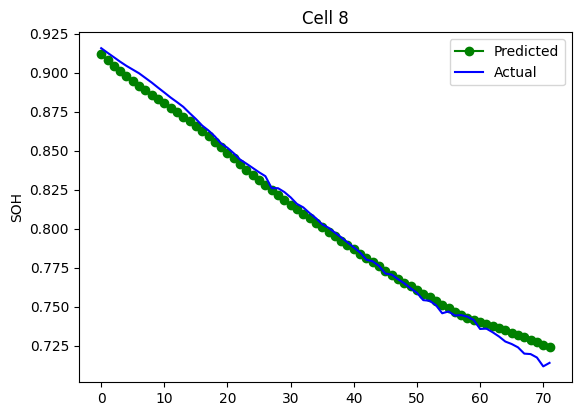

In [316]:
for i in range(0, 4):
    print("LSTM Evaluation for Cell {}".format(i + 5))
    lstm_outputs, targets, lstm_MAE, lstm_RMSE = evaluate(lstm_model, test_x[i], test_y[i], label_sc)
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(lstm_outputs[0][-100:], "-o", color="g", label="Predicted")
    plt.plot(targets[0][-100:], color="b", label="Actual")
    plt.ylabel('SOH')
    plt.title("Cell {}".format(i + 5))
    plt.legend()
    plt.show()

# MAE and RMSE
# predicted curve
# performance, numerical results